# Baseline with less context and a longer user query without Target and purpose.
Dashes are used


In [28]:
from openai import OpenAI
import pandas as pd

client = OpenAI()

df = pd.read_csv('verbs.csv')

def translate_verb(verb):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an expert in Moroccan Darija dialect and in translating Darija to English."},
            {"role": "user", "content": "Translate the provided Moroccan Darija dialect verbs into English using word-by-word translation." + 
             "The output must not be an infinitive verb. No explanations are needed in the output"},
            {"role": "assistant", "content": "OK, I understand. I am ready for the verb translation."},
            {"role": "user", "content": f"{verb}"},
        ],
        temperature=0.1  
    )
    return completion.choices[0].message.content

df['english_translation'] = df['darija_ar'].apply(translate_verb)


# Display or save the resulting DataFrame


In [44]:
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn

dataset = df.copy()

columns_to_delete = ['n2', 'n3', 'n4', 'n5', 'n6']
dataset.drop(columns=columns_to_delete, inplace=True)

eng = dataset['eng']
transl = dataset['english_translation']
transl = [verb.replace(" ", "_") for verb in transl]
eng = [verb.replace(" ", "_") for verb in eng]

def max_path_similarity(word1, word2):
    """Calculate the maximum path similarity between two words."""

    synsets1 = wn.synsets(word1, pos=wn.VERB)
    synsets2 = wn.synsets(word2, pos=wn.VERB)
    max_score = 0
    for syn1 in synsets1:
        for syn2 in synsets2:
            score = syn1.path_similarity(syn2)
            if score and score > max_score:
                max_score = score
    return max_score

def evaluate_pairs(threshold=0.5):
    """Evaluating each pair using WordNet path similarity and a threshold."""
    results = []
    for i in range(len(transl)):
        word1, word2 = transl[i], eng[i]
        similarity = max_path_similarity(word1, word2)
        results.append((word1, word2, similarity, similarity >= threshold))
    return results
results = evaluate_pairs()
similarities = [item[2] for item in results]

dataset['similarity'] = similarities
mean_similarity = dataset['similarity'].mean()


print(f'Mean value of similarities is: {mean_similarity}')
dataset.describe()



Mean value of similarities is: 0.401545714191063


,similarity
count,1032.000000
mean,0.401546
std,0.428889
min,0.000000
25%,0.000000
50%,0.250000
75%,1.000000
max,1.000000


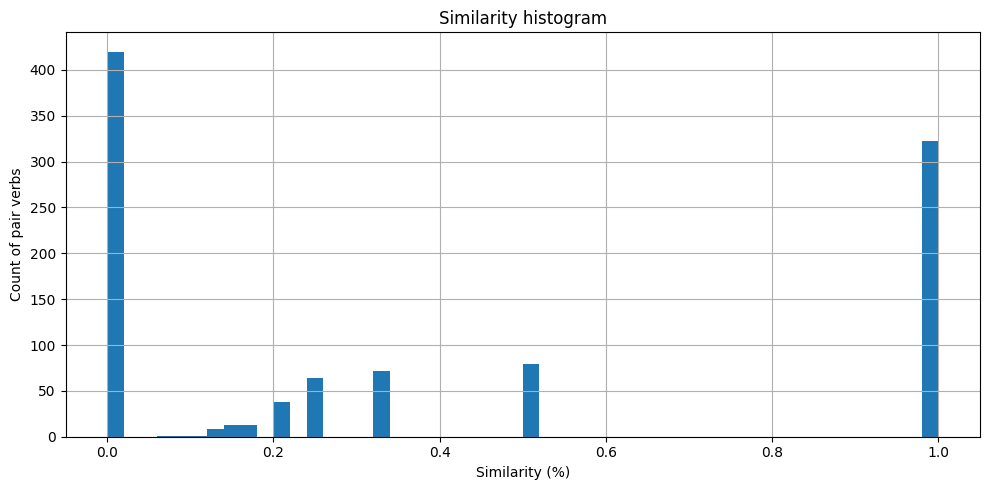

In [46]:
import matplotlib.pyplot as plt

dataset.hist(bins=50, figsize=(10,5))
plt.xlabel('Similarity (%)')
plt.ylabel('Count of pair verbs')
plt.title('Similarity histogram')
plt.tight_layout()
plt.grid(True)
plt.show()
